<a href="https://colab.research.google.com/github/kohys-dev/RedWineQuality/blob/main/02_Preprocessing_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [2]:
sns.set(style="whitegrid")
color = sns.color_palette("pastel")
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [3]:
df_origin = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/RedWine/winequality-red.csv', sep=';')
df_origin.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Feature Selection

In [4]:
# 성능이 오히려 떨어져서 사용하지 않음

# corr = df_origin.corr()['quality'].sort_values(ascending=False)
# features = [corr.index[i] for i in range(len(corr)) if abs(corr[i]) > 0.2]
# print(features)

# features.reverse()
# df_selected = df_origin[features]
# df_selected.head()

## Outlier 제거

In [5]:
def get_outliers(df, column, weight=1.5):
    q_25 = np.percentile(df[column].values, 25)
    q_75 = np.percentile(df[column].values, 75)
    IQR = (q_75-q_25)*weight
    lowest = q_25 - IQR
    highest = q_75 + IQR

    outlier_index = df[column][(df[column] < lowest) | (df[column] > highest)].index
    return outlier_index

In [6]:
df_removed = df_origin.copy()
data = {}
outliers_cnt = 0
for feature in df_origin.columns:
    outlier_index = get_outliers(df_removed, feature)
    data[feature] = outlier_index
    outliers_cnt += len(data[feature])
    df_removed.drop(outlier_index, axis=0, inplace=True)

print(outliers_cnt)

475


In [7]:
df_removed.shape

(1124, 12)

In [8]:
def draw_plot(df, plot):
    col_in_row = 3
    if len(df.columns) % col_in_row == 0:
        rows = len(df.columns)//col_in_row - 1
    rows = len(df.columns)//col_in_row

    fig, ax1 = plt.subplots(rows, col_in_row, figsize=(col_in_row*6,rows*4))
    k = 0
    palette = 'pastel'
    columns = list(df.columns)
    for i in range(rows):
        for j in range(col_in_row):
            try:
                if plot == 'distplot':
                    sns.distplot(df[columns[k]], ax = ax1[i][j], color = 'blue', kde=True )
                elif plot == 'boxplot':
                    sns.boxplot(df['quality'], df[columns[k]], ax = ax1[i][j], palette=palette)
                elif plot == 'violinplot':
                    sns.violinplot(df['quality'], df[columns[k]], ax = ax1[i][j], palette=palette)
                k += 1       
            except:
                break
            
    plt.show()

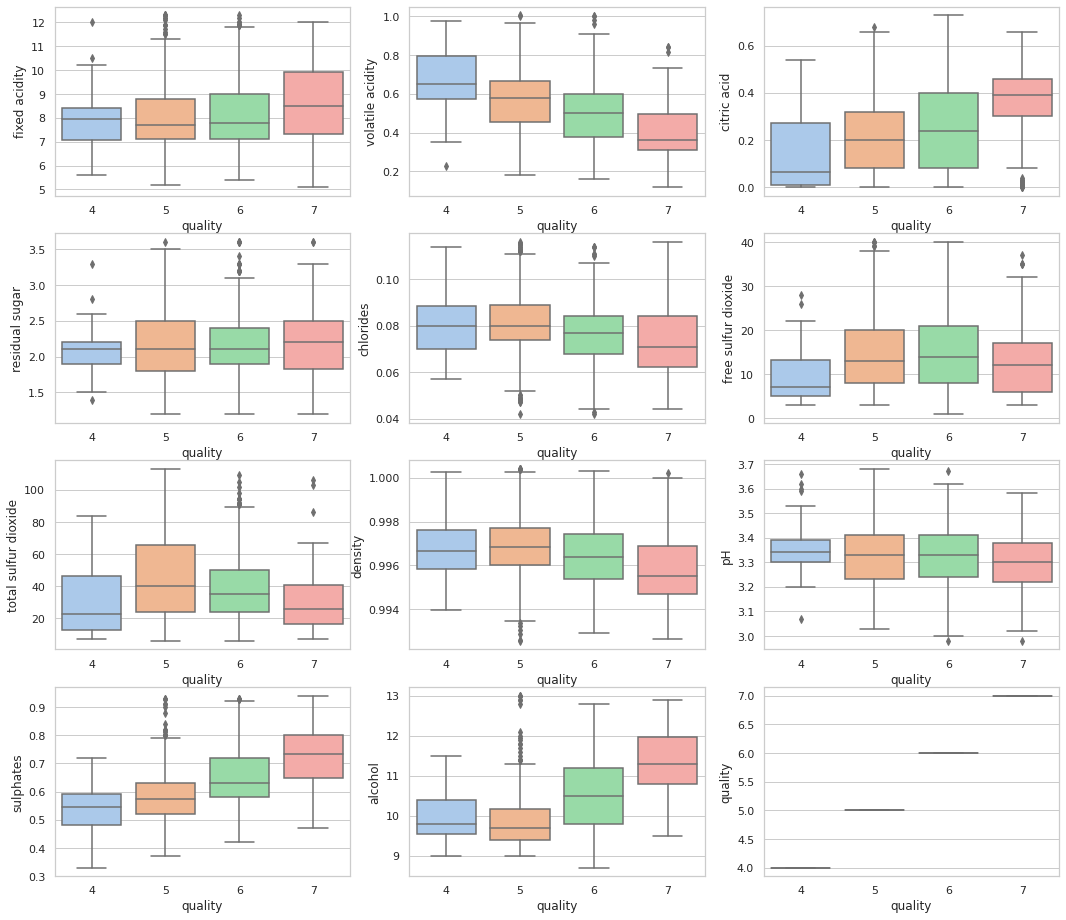

In [9]:
draw_plot(df_removed, 'boxplot')

## 정규화(log_transform)

In [10]:
def get_skew_kurt_score(df):
    for item in df.columns:    
        print('{:30}'.format(item), "Skewness: {:.3f}".format(df[item].skew()), "Kurtosis: {:.3f}".format(df[item].kurt()))

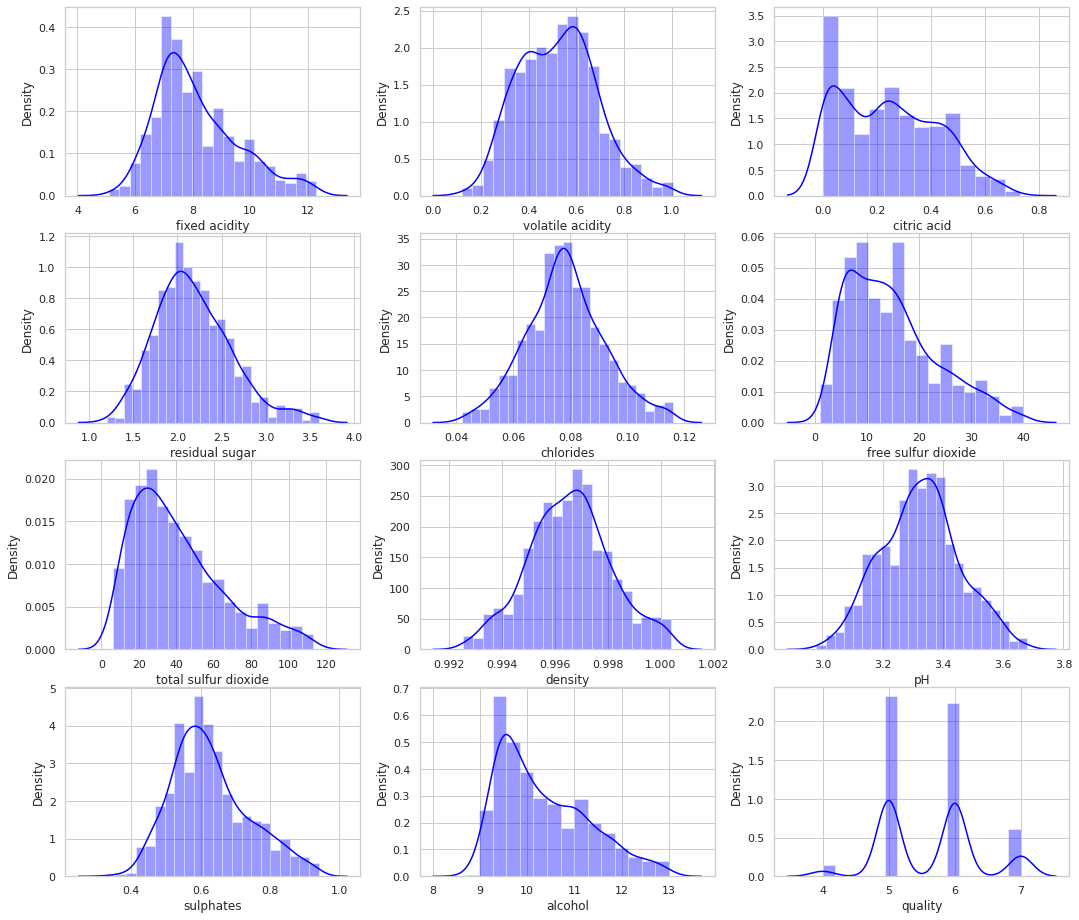

In [11]:
draw_plot(df_removed, 'distplot')

In [12]:
get_skew_kurt_score(df_removed)

fixed acidity                  Skewness: 0.777 Kurtosis: 0.132
volatile acidity               Skewness: 0.255 Kurtosis: -0.247
citric acid                    Skewness: 0.334 Kurtosis: -0.890
residual sugar                 Skewness: 0.626 Kurtosis: 0.459
chlorides                      Skewness: 0.165 Kurtosis: 0.061
free sulfur dioxide            Skewness: 0.791 Kurtosis: -0.060
total sulfur dioxide           Skewness: 0.911 Kurtosis: 0.151
density                        Skewness: 0.088 Kurtosis: -0.136
pH                             Skewness: 0.088 Kurtosis: -0.288
sulphates                      Skewness: 0.557 Kurtosis: -0.105
alcohol                        Skewness: 0.740 Kurtosis: -0.299
quality                        Skewness: 0.259 Kurtosis: -0.485


In [13]:
df_log = df_removed.copy()
df_log['citric acid'] = df_log['citric acid'] + 1

for item in df_log.columns:
    if abs(df_log[item].skew()) > 0.5 or abs(df_log[item].kurt()) > 0.5:
        df_log[item] = np.log(df_log[item])

In [14]:
get_skew_kurt_score(df_log)

fixed acidity                  Skewness: 0.386 Kurtosis: -0.293
volatile acidity               Skewness: 0.255 Kurtosis: -0.247
citric acid                    Skewness: 0.133 Kurtosis: -1.086
residual sugar                 Skewness: 0.044 Kurtosis: -0.042
chlorides                      Skewness: 0.165 Kurtosis: 0.061
free sulfur dioxide            Skewness: -0.366 Kurtosis: -0.360
total sulfur dioxide           Skewness: -0.252 Kurtosis: -0.572
density                        Skewness: 0.088 Kurtosis: -0.136
pH                             Skewness: 0.088 Kurtosis: -0.288
sulphates                      Skewness: 0.123 Kurtosis: -0.234
alcohol                        Skewness: 0.592 Kurtosis: -0.571
quality                        Skewness: 0.259 Kurtosis: -0.485


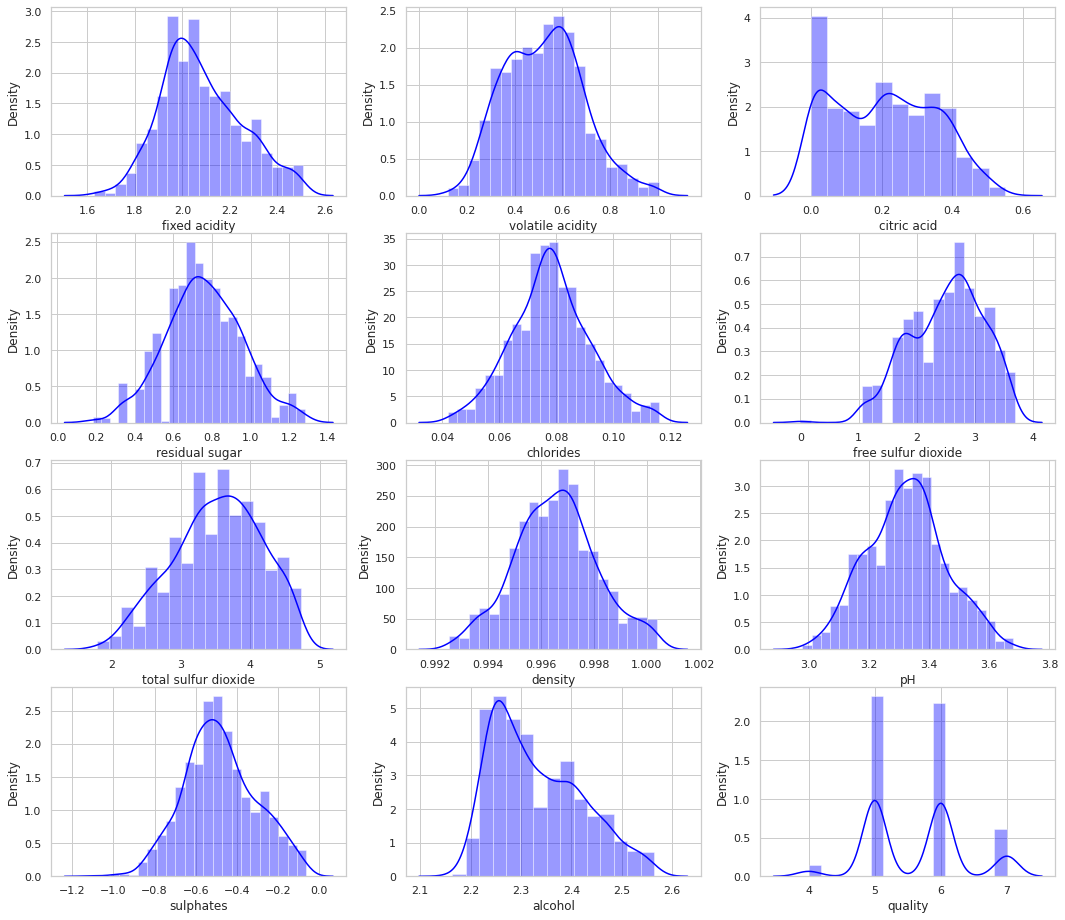

In [15]:
draw_plot(df_log, 'distplot')

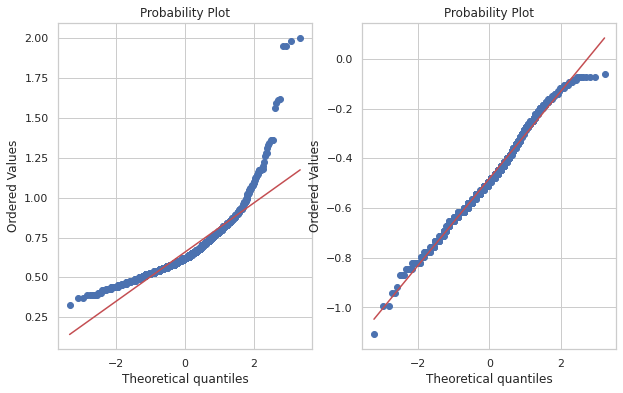

In [16]:
from scipy import stats

fig = plt.figure(figsize = (10,6))

fig.add_subplot(1,2,1)
res = stats.probplot(df_origin['sulphates'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(df_log['sulphates'], plot=plt)

## 스케일링

In [17]:
X = df_log.iloc[:, :-1]
Y = df_log['quality']

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold

split_train = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_train.split(X, Y):
    strat_train_x = X.iloc[train_index]
    strat_train_y = Y.iloc[train_index]
    strat_test_x = X.iloc[test_index]
    strat_test_y = Y.iloc[test_index]

In [19]:
# minmax = MinMaxScaler()
standard = StandardScaler()
robust = RobustScaler()

In [20]:
x_train = robust.fit_transform(strat_train_x)
x_test = robust.fit_transform(strat_test_x)
y_train = strat_train_y.to_numpy()
y_test = strat_test_y.to_numpy()

In [21]:
print("Train_x set's shape : {}".format(x_train.shape))
print("Train_y set's shape : {}".format(y_train.shape))
print("Test_x set's shape : {}".format(x_test.shape))
print("Test_y set's shape : {}".format(y_test.shape))

Train_x set's shape : (899, 11)
Train_y set's shape : (899,)
Test_x set's shape : (225, 11)
Test_y set's shape : (225,)


In [35]:
# data oversampling

from imblearn.over_sampling import SMOTE

sm = SMOTE(ratio='auto', kind='regular')
x_resampled, y_resampled = sm.fit_sample(x_train,list(y_train))
print(x_resampled.shape, y_resampled.shape)

(1568, 11) (1568,)


## Modeling

In [23]:
from sklearn.model_selection import cross_val_score , cross_validate
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from graphviz import Source
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
import xgboost
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVR, SVR

In [24]:
def evaluate_model(model):
    score = cross_validate(model, x_train, y_train, return_train_score=True, cv=10, scoring='neg_mean_squared_error')
    scores = cross_validate(model, x_resampled, y_resampled, return_train_score=True, cv=10, scoring='neg_mean_squared_error')
    print('train_mse : {:.4f}'.format(score['train_score'].mean() * (-1)))
    print('valid_mse : {:.4f}'.format(score['test_score'].mean() * (-1)))
    print('train_mse of sampling : {:.4f}'.format(scores['train_score'].mean() * (-1)))
    print('valid_mse of sampling: {:.4f}'.format(scores['test_score'].mean() * (-1)))

In [25]:
evaluate_model(lgb.LGBMRegressor())

train_mse : 0.0260
valid_mse : 0.2951
train_mse of sampling : 0.0224
valid_mse of sampling: 0.1916


In [26]:
evaluate_model(SVR(epsilon=1.5, kernel='poly'))

train_mse : 0.5392
valid_mse : 0.5394
train_mse of sampling : 1.2500
valid_mse of sampling: 1.2512


In [27]:
evaluate_model(KNeighborsRegressor())

train_mse : 0.2308
valid_mse : 0.3596
train_mse of sampling : 0.1695
valid_mse of sampling: 0.2982


In [28]:
evaluate_model(LogisticRegression())

train_mse : 0.3854
valid_mse : 0.3915
train_mse of sampling : 0.5367
valid_mse of sampling: 0.5606


In [29]:
evaluate_model(ElasticNet(alpha=0.1, l1_ratio=0.5))

train_mse : 0.3400
valid_mse : 0.3431
train_mse of sampling : 0.4883
valid_mse of sampling: 0.5722


In [30]:
evaluate_model(SGDRegressor())

train_mse : 0.3166
valid_mse : 0.3247
train_mse of sampling : 0.4559
valid_mse of sampling: 0.5238


In [31]:
evaluate_model(GradientBoostingRegressor())

train_mse : 0.1588
valid_mse : 0.3108
train_mse of sampling : 0.1634
valid_mse of sampling: 0.3040


In [32]:
evaluate_model(xgboost.XGBRegressor())

[00:16:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:16:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:16:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:16:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:16:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:16:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:16:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:16:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re